Implement a seasonal SARIMA model in Python.
extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the temperature.

########(https://medium.com/@llmkhoa511/time-series-analysis-and-weather-forecast-in-python-e80b664c7f71)


In [1]:
# import numpy,pandas for data manipulation
import numpy as np
import pandas as pd

In [3]:
# import seaborn and matplotlib for data visulization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

 (https://drive.google.com/drive/folders/1wpFT9fFw5zzq-ccTIPmczbseStsYp1YC (weather_data_test.csv))

In [6]:
#import dataset:

weather_data = pd.read_csv("/Users/fahmidaliza/Desktop/weather_data_test.csv", parse_dates=['datetime'],sep=';',
                          decimal=',',infer_datetime_format=True)

In [7]:
# check the shape of dataset
print(weather_data.shape)

(1346, 17)


In [8]:
# select the datetime and the temperature columns
temp_df = weather_data[['datetime','T_mu']]
temp_df.head(10)

,datetime,T_mu
0,2015-09-03,13.7375
1,2015-09-04,14.8250
2,2015-09-05,14.2750
3,2015-09-06,13.1250
4,2015-09-07,12.0875
5,2015-09-08,12.5375
6,2015-09-10,13.0625
7,2015-09-11,13.5375
8,2015-09-12,14.7500
9,2015-09-13,15.1375


In [9]:
# select the subset data from 2015 to 2019
mask = (temp_df['datetime']>='2016-01-01')&(temp_df['datetime']>='2019-05-21')

In [10]:
# Reset the index
temp_df.set_index("datetime",inplace=True)

In [11]:
# Inspect first 5 rows and last 5 rows of the data
from IPython.display import display
display(temp_df.head(5))
display(temp_df.tail(5))

,T_mu
datetime,
2015-09-03,13.7375
2015-09-04,14.8250
2015-09-05,14.2750
2015-09-06,13.1250
2015-09-07,12.0875


,T_mu
datetime,
2019-05-17,13.783333
2019-05-18,15.508333
2019-05-19,16.595833
2019-05-20,17.258333
2019-05-21,18.433333


In [12]:
# check out the min mode median quartiles
temp_df.describe()

,T_mu
count,1346.000000
mean,6.367627
std,8.180675
min,-22.675000
25%,0.768750
50%,5.535417
75%,13.424554
max,26.145833


In [13]:
# output the maximum and minimum temperature date
print(temp_df.loc[temp_df["T_mu"]==temp_df["T_mu"].max()])
print(temp_df.loc[temp_df["T_mu"]==temp_df["T_mu"].min()])

                 T_mu
datetime             
2018-07-17  26.145833
              T_mu
datetime          
2016-01-07 -22.675


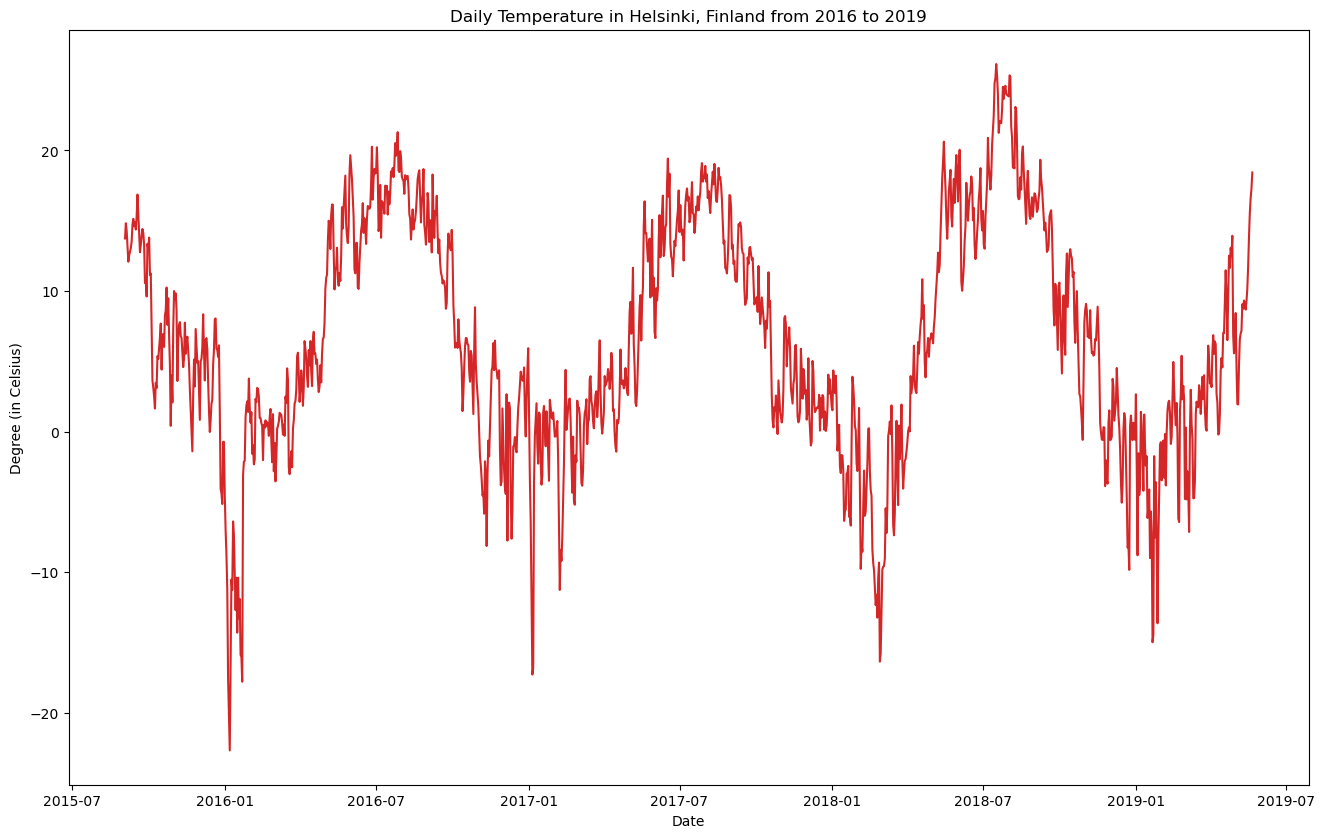

In [15]:
# plot the daily temperature change
plt.figure(figsize=(16,10),dpi=100)
plt.plot(temp_df.index, temp_df.T_mu,color='tab:red')
plt.gca().set(title="Daily Temperature in Helsinki, Finland from 2016 to 2019", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

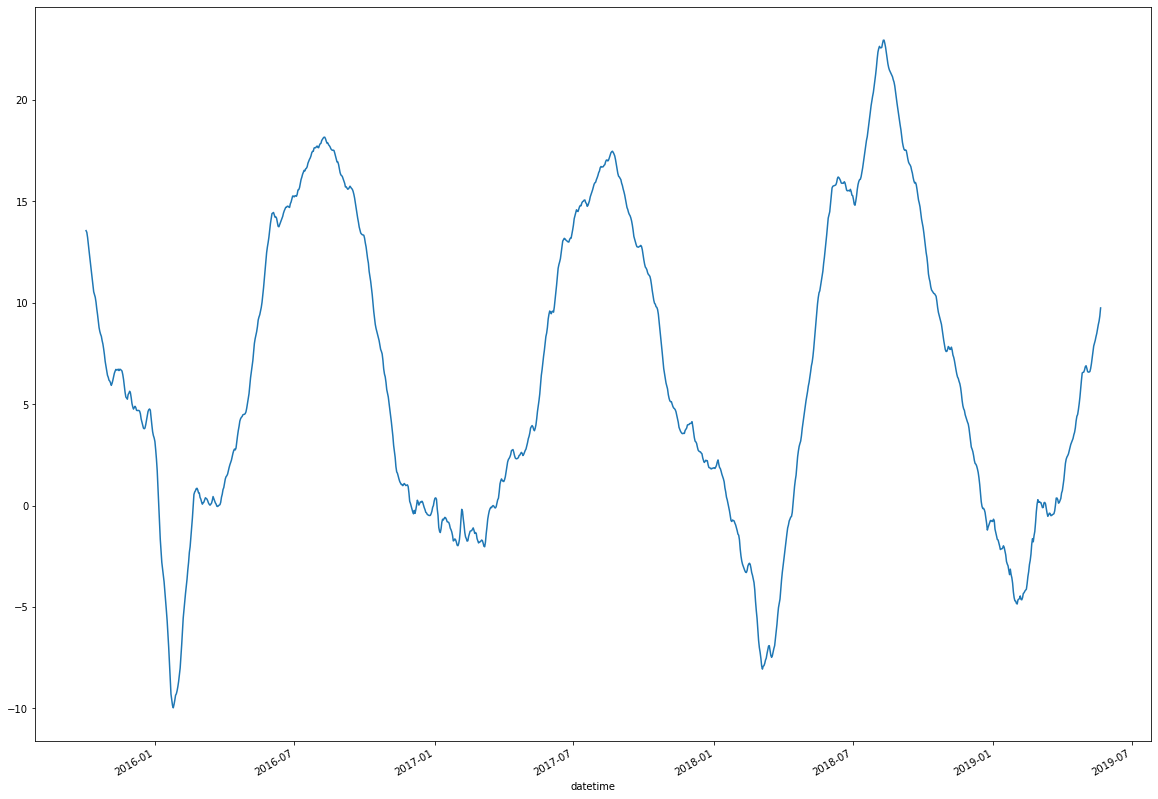

In [16]:
# Apply the Moving Average function by a subset of size 30 days.
temp_df_mean = temp_df.T_mu.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

Finnish weather is pretty harsh and cold, almost no sunlight during January and February, and there is a holiday called 'Midsummer Day' in June when Finns celebrate the comeback of the sun.

In [18]:
#Additive Decomposition:
result_add = seasonal_decompose(temp_df.T_mu, model='additive', extrapolate_trend='freq', freq=365)

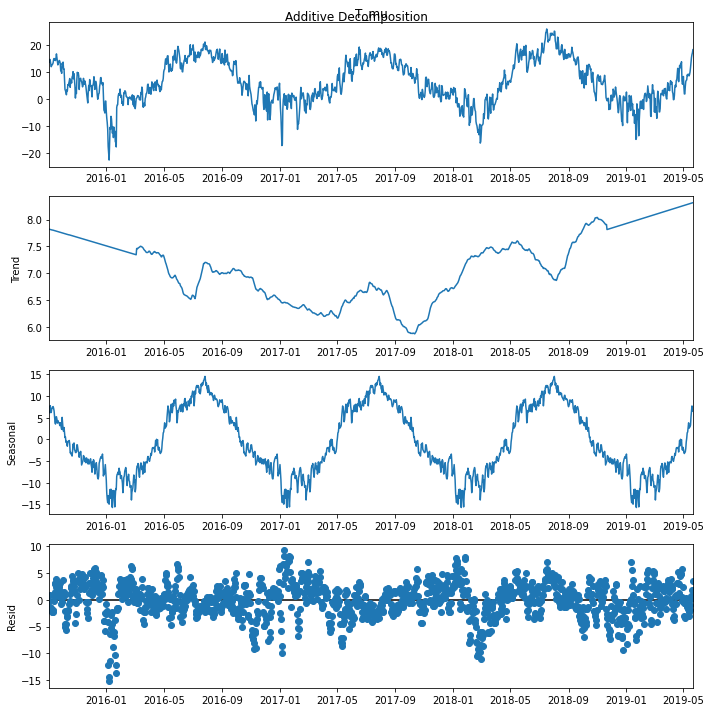

In [28]:
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=12)
plt.show()

In [20]:
#we would predict the weather based on an assumption: The air temperature today depends on the air temperature yesterday, the air temperature yesterday
#depends on the day before yesterday, and so on.

# Shift the current temperature to the next day. 
predicted_df = temp_df["T_mu"].to_frame().shift(1).rename(columns = {"T_mu": "T_mu_pred" })
actual_df = temp_df["T_mu"].to_frame().rename(columns = {"T_mu": "T_mu_actual" })

In [21]:
# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

In [22]:
# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,T_mu_actual,T_mu_pred
datetime,,
2015-09-04,14.8250,13.7375
2015-09-05,14.2750,14.8250
2015-09-06,13.1250,14.2750
2015-09-07,12.0875,13.1250
2015-09-08,12.5375,12.0875
2015-09-10,13.0625,12.5375
2015-09-11,13.5375,13.0625
2015-09-12,14.7500,13.5375
2015-09-13,15.1375,14.7500


In [23]:
#validate how well our model is by looking at the Root Mean Squared Error(RMSE) between the predicted and actual temperature:

from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

In [24]:
# Calculate the RMSE
temp_pred_err = sqrt(MSE(one_step_df.T_mu_actual, one_step_df.T_mu_pred))
print("The RMSE is",temp_pred_err)

The RMSE is 2.243130853613005


################################################################################
**asteriskss** The RMSE is small we can use the most basic 1-step prediction baseline model to predict 

The error is acceptable, especially in the Weather Forecast field 

Another widely-used technique for time series prediction is SARIMA Model.commonly used method for time-series

forecasting, known as SARIMA, which stands for Seasonal Autoregressive Integrated Moving Average.

SARIMA models are denoted with the notation SARIMA(p,d,q)(P,D,Q,s). These three parameters account for 

seasonality, trend, and noise in data We will use a “grid search” to iteratively explore different combinations 

of parameters. For each combination  of parameters, we fit a new seasonal SARIMA model with the SARIMAX()

function from the statsmodels module and assess its overall quality.

#######################################################################

In [25]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


##
AIC measures how well a model fits the data while taking into account the overall complexity of the model.
##

In [26]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

# Fitting the Model

In [27]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

In [29]:
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

# Model Diagnostics

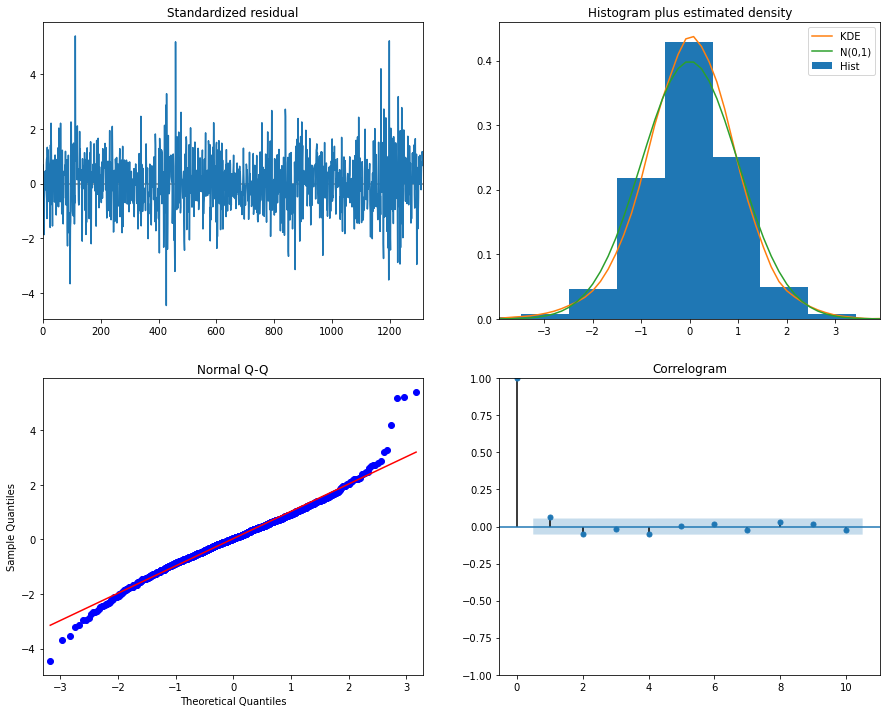

In [30]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

our model are uncorrelated and normally distributed with zero-mean. 

satisfy these properties, it is a good indication that it can be further improved.

model residuals are normally distributed based on the following:

1. red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal    distribution with mean 0 and standard deviation of 1). good indication that the residuals are normally distributed.

2. left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). 

# Validating the Non-Dynamic Forecast

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=False)
pred_ci = pred.conf_int()

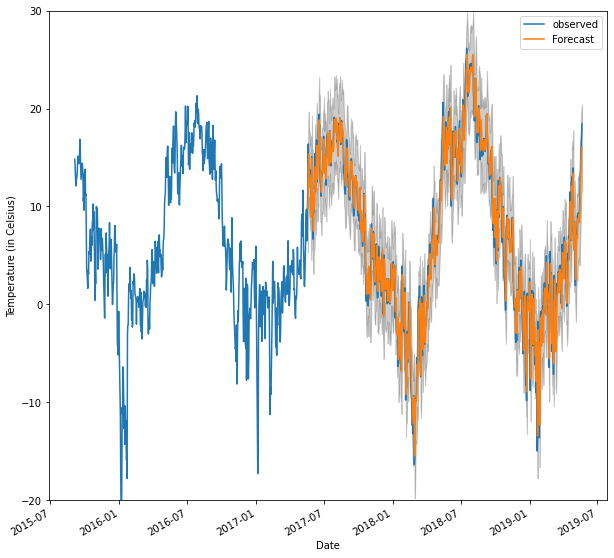

In [32]:
ax = one_step_df.T_mu_actual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

# Forecast Diagnostic

In [33]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.T_mu_actual['2017-05-19':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(727,)
(727,)
The Mean Squared Error of our forecasts is 2.19


In [34]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


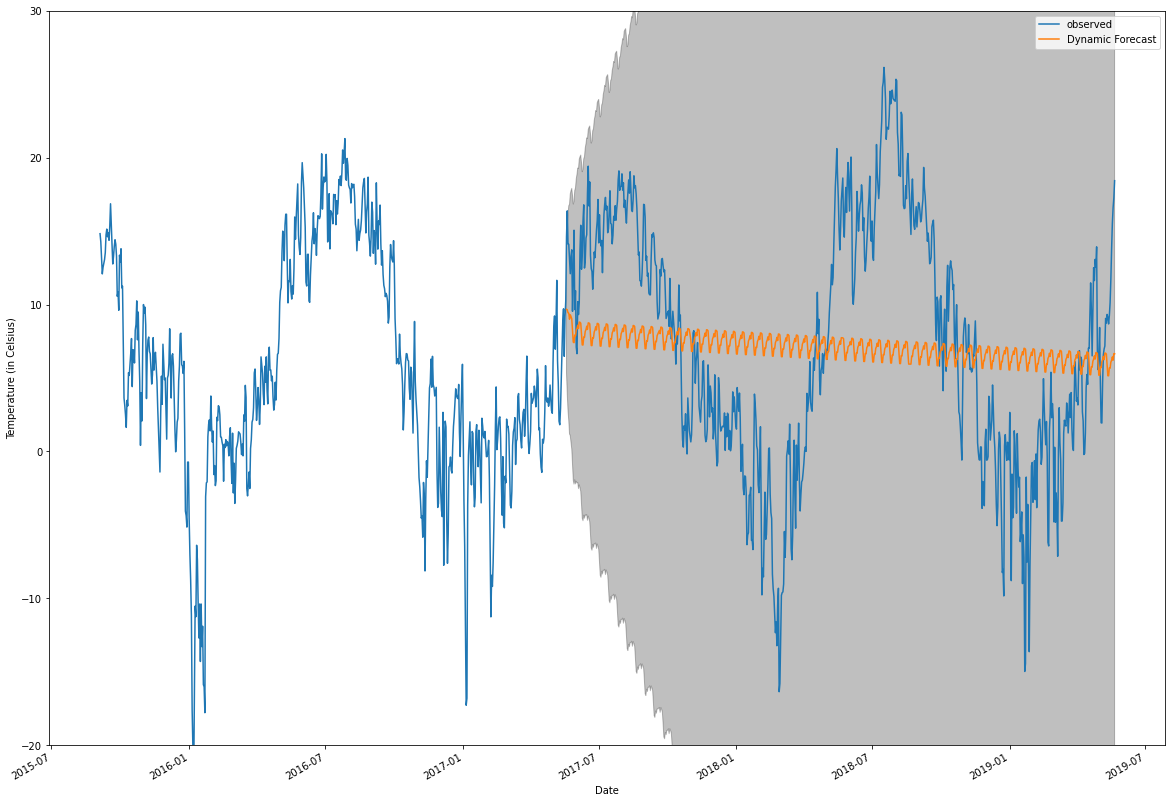

In [35]:
ax = one_step_df.T_mu_actual['2015':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()


In [36]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.T_mu_actual['2017-05-19':]

# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 8.35


For further explanation (https://medium.com/@llmkhoa511/time-series-analysis-and-weather-forecast-in-python-e80b664c7f71)